In [1]:
import numpy as np
import collections
import copy
from scipy.special import comb
from scipy.special import factorial2
from scipy.special import factorial

In [2]:
def getAngularQuanta(orbitaltype):
    if orbitaltype == "S":
        return 0, 0, 0
    if orbitaltype == "Px":
        return 1, 0, 0
    if orbitaltype == "Py":
        return 0, 1, 0
    if orbitaltype == "Pz":
        return 0, 0, 1
    if orbitaltype == "Dx2":
        return 2, 0, 0
    if orbitaltype == "Dy2":
        return 0, 2, 0
    if orbitaltype == "Dz2":
        return 0, 0, 2
    if orbitaltype == "Dxy":
        return 1, 1, 0
    if orbitaltype == "Dyz":
        return 0, 1, 1
    if orbitaltype == "Dzx":
        return 1, 0, 1

In [3]:
def getorbitalType(angular):
    if angular == (0,0,0):
        return "S"
    if angular == (1,0,0):
        return "Px"
    if angular == (0,1,0):
        return "Py"
    if angular == (0,0,1):
        return "Pz"
    if angular == (2,0,0):
        return "Dx2"
    if angular == (0,2,0):
        return "Dy2"
    if angular == (0,0,2):
        return "Dz2"
    if angular == (1,1,0):
        return "Dxy"
    if angular == (0,1,1):
        return "Dyz"
    if angular == (1,0,1):
        return "Dzx"

In [4]:
class Gprimitive: #gaussian primitive class for only one variable. The total will be product of gprimitive(x)*gprimitive(y)*gprimitive(z)
    def __init__(self, angular, center, exponent):
        self.angular = angular
        self.center = center
        self.exponent = exponent
    
    def __call__(self, x):
        return (x - self.center)**self.angular*np.exp(-self.exponent*(x-self.center)**2)
    
    def __repr__(self):
        return str(self.center)+str(self.angular)+str(self.exponent)

In [5]:
class Ao(object): #atomic orbital
    def __init__(self, center, angular, contract_num):
        self.center = center # the center of the atomic orbital
        self.exponents = [0 for i in range(contract_num)] #list of gaussian primitive exponents
        self.coeffs = [0 for i in range(contract_num)] #list of gaussian primivite coeffs
        self.angular = angular #angular momentum could be S, Px, Py, Pz, Dx2, Dy2, Dz2, Dxy, Dyz, Dzx, ... (0,0,0), (1,0,0),(0,1,0)...
        
    def __repr__(self):
        return getorbitalType(self.angular) + str(self.center) + str(self.exponents) + str(self.coeffs)
    
    def __call__(self, x, y, z):
        res = 0
        x0, y0, z0 = self.center
        l, m, n = self.angular
        for i in range(len(self.coeffs)):
            exponent = self.exponents[i]
            gprimitivex = Gprimitive(l, x0, exponent)
            gprimitivey = Gprimitive(m, y0, exponent)
            gprimitivez = Gprimitive(n, z0, exponent)
            res += self.coeffs[i]*gprimitivex(x)*gprimitivey(y)*gprimitivez(z)
        return res

In [6]:
class Mo(object): #molecular orbital->linear combination of atomic orbitals
    def __init__(self, aolist, coeffs):
        self.aolist = aolist
        self.coeffs = coeffs
        
    def __repr__(self):
        return str(self.coeffs) + repr(self.aolist)
    
    def __call__(self, x, y, z):
        res = 0
        for i in range(len(self.aolist)):
            ao = aolist[i]
            res += self.coeffs[i]*ao(x, y, z)
        return res

In [7]:
file = open("3-21G.dat")
aodict = collections.defaultdict(list)
newatomtype = False
contract_num = None
origin = (0,0,0)
orbitalType = None
for line in file:
    if line.strip() == "****":
        newatomtype = True
        linecount = 0
    elif line.strip() != "****" and newatomtype == True:
        if linecount == 0:
            atomtype, _ = line.split()
            linecount += 1
            print(atomtype)
        elif linecount == 1:
            orbitalType, contract_num, _ = line.split()
            contract_num = int(contract_num)
            if orbitalType == "S":
                aos = Ao(origin, (0,0,0), contract_num)
                aodict[atomtype].append(aos)
            elif orbitalType == "P":
                aopx = Ao(origin,(1,0,0), contract_num)
                aopy = Ao(origin,(0,1,0), contract_num)
                aopz = Ao(origin,(0,0,1), contract_num)
                aodict[atomtype].append(aopx)
                aodict[atomtype].append(aopy)
                aodict[atomtype].append(aopz)
            elif orbitalType == "D":
                aodx2 = Ao(origin,(2,0,0), contract_num)
                aody2 = Ao(origin,(0,2,0), contract_num)
                aodz2 = Ao(origin,(0,0,2), contract_num)
                aodxy = Ao(origin,(1,1,0), contract_num)
                aodyz = Ao(origin,(0,1,1), contract_num)
                aodzx = Ao(origin,(1,0,1), contract_num)
                aodict[atomtype].append(aodx2)
                aodict[atomtype].append(aody2)
                aodict[atomtype].append(aodz2)
                aodict[atomtype].append(aodxy)
                aodict[atomtype].append(aodyz)
                aodict[atomtype].append(aodzx)
            elif orbitalType == "SP":
                aos = Ao(origin,(0,0,0), contract_num)
                aodict[atomtype].append(aos)
                aopx = Ao(origin,(1,0,0), contract_num)
                aopy = Ao(origin,(0,1,0), contract_num)
                aopz = Ao(origin,(0,0,1), contract_num)
                aodict[atomtype].append(aopx)
                aodict[atomtype].append(aopy)
                aodict[atomtype].append(aopz)
            linecount += 1
            print(orbitalType, contract_num)
        elif contract_num and 1 <linecount <= 1 + contract_num:
            if orbitalType == "S" or orbitalType == "P" or orbitalType == "D":
                exponent, coeff = line.split()
                exponent = float(exponent.replace('D', 'E'))
                coeff = float(coeff.replace('D', 'E'))
                if orbitalType == "S":
                    aos.exponents[linecount - 2] = exponent
                    aos.coeffs[linecount - 2] = coeff
                elif orbitalType == "P":
                    aopx.exponents[linecount - 2] = exponent
                    aopy.exponents[linecount - 2] = exponent
                    aopz.exponents[linecount - 2] = exponent
                    aopx.coeffs[linecount - 2] = coeff
                    aopy.coeffs[linecount - 2] = coeff
                    aopz.coeffs[linecount - 2] = coeff
                elif orbitalType == "D":
                    aodx2.exponents[linecount - 2] = exponent
                    aody2.exponents[linecount - 2] = exponent
                    aodz2.exponents[linecount - 2] = exponent
                    aodxy.exponents[linecount - 2] = exponent
                    aodyz.exponents[linecount - 2] = exponent
                    aodzx.exponents[linecount - 2] = exponent
                    aodx2.coeffs[linecount - 2] = coeff
                    aody2.coeffs[linecount - 2] = coeff
                    aodz2.coeffs[linecount - 2] = coeff
                    aodxy.coeffs[linecount - 2] = coeff
                    aodyz.coeffs[linecount - 2] = coeff
                    aodzx.coeffs[linecount - 2] = coeff
                print(exponent, coeff)
            elif orbitalType == "SP":
                exponent, coeffs, coeffp = line.split()
                exponent = float(exponent.replace('D', 'E'))
                coeffs = float(coeffs.replace('D', 'E'))
                coeffp = float(coeffp.replace('D', 'E'))
                aos.exponents[linecount - 2] = exponent
                aos.coeffs[linecount - 2] = coeffs
                aopx.exponents[linecount - 2] = exponent
                aopy.exponents[linecount - 2] = exponent
                aopz.exponents[linecount - 2] = exponent
                aopx.coeffs[linecount - 2] = coeffp
                aopy.coeffs[linecount - 2] = coeffp
                aopz.coeffs[linecount - 2] = coeffp
                print(exponent, coeffs, coeffp)
            if linecount < 1 + int(contract_num):
                linecount += 1
            else:
                linecount = 1

H
S 2
5.447178 0.1562849787
0.82454724 0.9046908767
S 1
0.18319158 1.0
O
S 3
322.037 0.05923939339
48.4308 0.3514999608
10.4206 0.707657921
SP 2
7.40294 -0.4044535832 0.244586107
1.5762 1.221561761 0.8539553735
SP 1
0.373684 1.0 1.0


In [8]:
for key in aodict:
    print(key)

H
O


In [9]:
for x in aodict['H']:
    print(x)

S(0, 0, 0)[5.447178, 0.82454724][0.1562849787, 0.9046908767]
S(0, 0, 0)[0.18319158][1.0]


In [10]:
for x in aodict['O']:
    print(x)

S(0, 0, 0)[322.037, 48.4308, 10.4206][0.05923939339, 0.3514999608, 0.707657921]
S(0, 0, 0)[7.40294, 1.5762][-0.4044535832, 1.221561761]
Px(0, 0, 0)[7.40294, 1.5762][0.244586107, 0.8539553735]
Py(0, 0, 0)[7.40294, 1.5762][0.244586107, 0.8539553735]
Pz(0, 0, 0)[7.40294, 1.5762][0.244586107, 0.8539553735]
S(0, 0, 0)[0.373684][1.0]
Px(0, 0, 0)[0.373684][1.0]
Py(0, 0, 0)[0.373684][1.0]
Pz(0, 0, 0)[0.373684][1.0]


In [11]:
geomfile = open("H2O.xyz")
aolist = []
atomlist = []
for line in geomfile:
    atomtype, x, y, z = line.split()
    x = float(x)
    y = float(y)
    z = float(z)
    x = x * 1.8897261339213 # from Angstrom to atomic unit
    y = y * 1.8897261339213 # from Angstrom to atomic unit
    z = z * 1.8897261339213 # ....
    atomlist.append((atomtype, (x, y, z)))
    if atomtype in aodict:
        for ao in aodict[atomtype]:
            aonew = copy.copy(ao)
            aonew.center = [x,y,z]
            aolist.append(aonew)

In [12]:
for ao in aolist:
    print(ao)

S[0.0, 0.0, 0.22259084131458995][322.037, 48.4308, 10.4206][0.05923939339, 0.3514999608, 0.707657921]
S[0.0, 0.0, 0.22259084131458995][7.40294, 1.5762][-0.4044535832, 1.221561761]
Px[0.0, 0.0, 0.22259084131458995][7.40294, 1.5762][0.244586107, 0.8539553735]
Py[0.0, 0.0, 0.22259084131458995][7.40294, 1.5762][0.244586107, 0.8539553735]
Pz[0.0, 0.0, 0.22259084131458995][7.40294, 1.5762][0.244586107, 0.8539553735]
S[0.0, 0.0, 0.22259084131458995][0.373684][1.0]
Px[0.0, 0.0, 0.22259084131458995][0.373684][1.0]
Py[0.0, 0.0, 0.22259084131458995][0.373684][1.0]
Pz[0.0, 0.0, 0.22259084131458995][0.373684][1.0]
S[0.0, 1.427593607870846, -0.8903633652583598][5.447178, 0.82454724][0.1562849787, 0.9046908767]
S[0.0, 1.427593607870846, -0.8903633652583598][0.18319158][1.0]
S[0.0, -1.427593607870846, -0.8903633652583598][5.447178, 0.82454724][0.1562849787, 0.9046908767]
S[0.0, -1.427593607870846, -0.8903633652583598][0.18319158][1.0]


In [15]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

def plot_implicit(fn, isovalue, bbox=(-2.5,2.5),elev=0, azim=30):
    ''' create a plot of an implicit function
    fn  ...implicit function (plot where fn==0)
    bbox ..the x,y,and z limits of plotted interval'''
    xmin, xmax, ymin, ymax, zmin, zmax = bbox*3
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    A = np.linspace(xmin, xmax, 100) # resolution of the contour
    B = np.linspace(xmin, xmax, 15) # number of slices
    A1,A2 = np.meshgrid(A,A) # grid on which the contour is plotted

    for z in B: # plot contours in the XY plane
        X,Y = A1,A2
        Z = fn(X,Y,z) - isovalue
        cset = ax.contour(X, Y, Z+z, [z], zdir='z', colors='red')
        # [z] defines the only level to plot for this contour for this value of z

    for y in B: # plot contours in the XZ plane
        X,Z = A1,A2
        Y = fn(X,y,Z) - isovalue
        cset = ax.contour(X, Y+y, Z, [y], zdir='y', colors='red')

    for x in B: # plot contours in the YZ plane
        Y,Z = A1,A2
        X = fn(x,Y,Z) - isovalue
        cset = ax.contour(X+x, Y, Z, [x], zdir='x', colors='red')
        
## now plot the negative part
    for z in B: # plot contours in the XY plane
        X,Y = A1,A2
        Z = fn(X,Y,z) + isovalue
        cset = ax.contour(X, Y, Z+z, [z], zdir='z', colors='blue')
        # [z] defines the only level to plot for this contour for this value of z

    for y in B: # plot contours in the XZ plane
        X,Z = A1,A2
        Y = fn(X,y,Z) + isovalue
        cset = ax.contour(X, Y+y, Z, [y], zdir='y', colors='blue')

    for x in B: # plot contours in the YZ plane
        Y,Z = A1,A2
        X = fn(x,Y,Z) + isovalue
        cset = ax.contour(X+x, Y, Z, [x], zdir='x', colors='blue')

    # must set plot limits because the contour will likely extend
    # way beyond the displayed level.  Otherwise matplotlib extends the plot limits
    # to encompass all values in the contour.
    ax.set_zlim3d(zmin,zmax)
    ax.set_xlim3d(xmin,xmax)
    ax.set_ylim3d(ymin,ymax)
    ax.view_init(elev, azim)
    plt.show()

<ipython-input-15-5deb4145c39d>:19: UserWarning: No contour levels were found within the data range.
  cset = ax.contour(X, Y, Z+z, [z], zdir='z', colors='red')
<ipython-input-15-5deb4145c39d>:25: UserWarning: No contour levels were found within the data range.
  cset = ax.contour(X, Y+y, Z, [y], zdir='y', colors='red')
<ipython-input-15-5deb4145c39d>:30: UserWarning: No contour levels were found within the data range.
  cset = ax.contour(X+x, Y, Z, [x], zdir='x', colors='red')
<ipython-input-15-5deb4145c39d>:36: UserWarning: No contour levels were found within the data range.
  cset = ax.contour(X, Y, Z+z, [z], zdir='z', colors='blue')
<ipython-input-15-5deb4145c39d>:42: UserWarning: No contour levels were found within the data range.
  cset = ax.contour(X, Y+y, Z, [y], zdir='y', colors='blue')
<ipython-input-15-5deb4145c39d>:47: UserWarning: No contour levels were found within the data range.
  cset = ax.contour(X+x, Y, Z, [x], zdir='x', colors='blue')


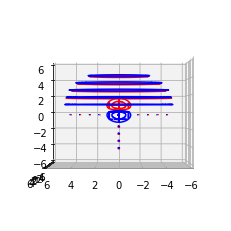

In [21]:
plot_implicit(aolist[4], 0.05,[-6,6],0,90) #Pz orbital on Oxygen.

In [22]:
def gint(m, center1, exponent1, n, center2, exponent2): #calculate one electron integral of two gaussian primitives
    newcenter = (exponent1 * center1 + exponent2 * center2) / (exponent1 + exponent2)
    newexponent = exponent1 + exponent2
    tempexponent = exponent1 * exponent2 / (exponent1 + exponent2)
    e12 = np.exp(-tempexponent*(center1 - center2)**2)
    res = 0
    for i in range(m + 1):
        for j in range(n + 1):
            if (i + j) % 2 == 0:
                res += (np.sqrt(np.pi/newexponent)*comb(m, i)*comb(n, j)*
                        factorial2(i + j - 1)/(2*newexponent)**((i + j)/2)*
                        (newcenter - center1)**(m - i)*(newcenter - center2)**(n - j)
                       )
    res = e12 * res
    return res

In [23]:
def E(l1, l2, t, center1, center2, exponent1, exponent2):#calculate the gaussian-hermite expansion coefficient using recurence
    newcenter = (exponent1 * center1 + exponent2 * center2) / (exponent1 + exponent2)
    sumexponent = exponent1 + exponent2
    diffcenter = center1 - center2
    redexponent = exponent1 * exponent2 / (exponent1 + exponent2)
    if t > l1 + l2:
        return 0
    if l1 < 0 or l2 < 0 or t < 0:
        return 0
    elif l1 == 0 and l2 == 0 and t == 0:
        return np.exp(-redexponent*diffcenter**2)
    elif l1 > 0:
        return (1/(2*sumexponent)*E(l1-1, l2, t - 1,center1,center2,exponent1,exponent2)
                +(newcenter - center1)*E(l1-1,l2,t,center1,center2,exponent1,exponent2)
                +(t + 1)*E(l1-1,l2, t+1, center1,center2,exponent1,exponent2))
    elif l1 == 0:
        return (1/(2*sumexponent)*E(l1, l2-1, t - 1,center1,center2,exponent1,exponent2)
                +(newcenter - center2)*E(l1,l2-1,t,center1,center2,exponent1,exponent2)
                +(t + 1)*E(l1,l2-1, t+1, center1,center2,exponent1,exponent2))
    return 0

In [24]:
def S(m1, m2, center1, center2, exponent1, exponent2): #calculate overlap type integral
    return np.sqrt(np.pi/(exponent1 + exponent2))*E(m1, m2, 0, center1, center2, exponent1, exponent2)

In [25]:
def T(m1, m2, center1, center2, exponent1, exponent2): #calculate kinetic type integral
    res = 0
    res += -2*exponent2*S(m1, m2 + 2, center1, center2, exponent1, exponent2)
    res += exponent2*(2*m2+1)*S(m1, m2, center1, center2, exponent1, exponent2)
    res += -1/2*m2*(m2-1)*S(m1, m2 - 2, center1, center2, exponent1, exponent2)
    return res

In [26]:
def F(n, x): #calculate Boys function value by numerical integration
    if x < 1e-7:
        return 1/(2*n + 1)
    if n == 20:
        res1 = 1/(2*n + 1)
        #if x < 1e-7:
        #    return res1
        for k in range(1,11):
            res1 += (-x)**k/factorial(k)/(2*n+2*k+1)
        res2 = factorial2(2*n-1)/2**(n+1)*np.sqrt(np.pi/x**(2*n+1))
        res = min(res1, res2)
        return res
    return (2*x*F(n+1,x)+np.exp(-x))/(2*n+1)


In [27]:
def R(t, u, v, n, p, x, y, z):
    if t < 0 or u < 0 or v < 0:
        return 0
    if t == 0 and u == 0 and v == 0:
        return (-2*p)**n*F(n,p*(x**2+y**2+z**2))
    if t > 0:
        return (t-1)*R(t-2,u,v,n+1,p,x,y,z)+x*R(t-1,u,v,n+1,p,x,y,z)
    if u > 0:
        return (u-1)*R(t,u-2,v,n+1,p,x,y,z)+y*R(t,u-1,v,n+1,p,x,y,z)
    if v > 0:
        return (v-1)*R(t,u,v-2,n+1,p,x,y,z)+z*R(t,u,v-1,n+1,p,x,y,z)

In [28]:
def overlap(ao1, ao2): #calculate overlap matrix <psi|phi>
    l1, m1, n1 = ao1.angular
    l2, m2, n2 = ao2.angular
    x1, y1, z1 = ao1.center
    x2, y2, z2 = ao2.center
    res = 0
    for i in range(len(ao1.coeffs)):
        for j in range(len(ao2.coeffs)):
            exponent1 = ao1.exponents[i]
            exponent2 = ao2.exponents[j]
            #res += (ao1.coeffs[i]*ao2.coeffs[j]*
            #        gint(l1, x1, exponent1, l2, x2, exponent2)*
            #        gint(m1, y1, exponent1, m2, y2, exponent2)*
            #        gint(n1, z1, exponent1, n2, z2, exponent2))
            res += (ao1.coeffs[i]*ao2.coeffs[j]*
                    S(l1, l2, x1, x2, exponent1, exponent2)*
                    S(m1, m2, y1, y2, exponent1, exponent2)*
                    S(n1, n2, z1, z2, exponent1, exponent2))
    return res

In [29]:
def kinetic(ao1, ao2): #calculate kinetic integral <psi|-1/2*del^2|phi>
    l1, m1, n1 = ao1.angular
    l2, m2, n2 = ao2.angular
    x1, y1, z1 = ao1.center
    x2, y2, z2 = ao2.center
    res = 0
    for i in range(len(ao1.coeffs)):
        for j in range(len(ao2.coeffs)):
            exponent1 = ao1.exponents[i]
            exponent2 = ao2.exponents[j]
            res += (ao1.coeffs[i]*ao2.coeffs[j]*
                    (T(l1,l2,x1,x2,exponent1,exponent2)*S(m1,m2,y1,y2,exponent1,exponent2)*S(n1,n2,z1,z2,exponent1,exponent2) +
                     S(l1,l2,x1,x2,exponent1,exponent2)*T(m1,m2,y1,y2,exponent1,exponent2)*S(n1,n2,z1,z2,exponent1,exponent2) +
                     S(l1,l2,x1,x2,exponent1,exponent2)*S(m1,m2,y1,y2,exponent1,exponent2)*T(n1,n2,z1,z2,exponent1,exponent2))
                   )
    return res

In [30]:
def oneelectron(ao1, centerC, ao2):
    l1, m1, n1 = ao1.angular
    l2, m2, n2 = ao2.angular
    a = l1 + m1 + n1
    b = l2 + m2 + n2
    c = a + b
    x1, y1, z1 = ao1.center
    x2, y2, z2 = ao2.center
    xc, yc, zc = centerC # coordinate of atom with charge Z
    res = 0
    for i in range(len(ao1.coeffs)):
        for j in range(len(ao2.coeffs)):
            exponent1 = ao1.exponents[i]
            exponent2 = ao2.exponents[j]
            p = exponent1 + exponent2
            xp = (exponent1*x1+exponent2*x2)/p
            yp = (exponent1*y1+exponent2*y2)/p
            zp = (exponent1*z1+exponent2*z2)/p
            xpc = xp - xc
            ypc = yp - yc
            zpc = zp - zc
            for t in range(c+1):
                for u in range(c+1):
                    for v in range(c+1):
                        res += (ao1.coeffs[i]*ao2.coeffs[j]*
                                2*np.pi/p*E(l1,l2,t,x1,x2,exponent1,exponent2)*
                                E(m1,m2,u,y1,y2,exponent1,exponent2)*
                                E(n1,n2,v,z1,z2,exponent1,exponent2)*
                                R(t,u,v,0,p,xpc,ypc,zpc))
    return res

In [31]:
def twoelectron(ao1, ao2, ao3, ao4):
    res = 0
    l1, m1, n1 = ao1.angular
    l2, m2, n2 = ao2.angular
    l3, m3, n3 = ao3.angular
    l4, m4, n4 = ao4.angular
    x1, y1, z1 = ao1.center
    x2, y2, z2 = ao2.center
    x3, y3, z3 = ao3.center
    x4, y4, z4 = ao4.center
    a = l1 + m1 + n1
    b = l2 + m2 + n2
    c = l3 + m3 + n3
    d = l4 + m4 + n4
    for i in range(len(ao1.coeffs)):
        for j in range(len(ao2.coeffs)):
            for k in range(len(ao3.coeffs)):
                for l in range(len(ao4.coeffs)):
                    exponent1 = ao1.exponents[i]
                    exponent2 = ao2.exponents[j]
                    exponent3 = ao3.exponents[k]
                    exponent4 = ao4.exponents[l]
                    p = (exponent1 + exponent2)
                    q = (exponent3 + exponent4)
                    alpha = p*q/(p + q)
                    xp = (x1*exponent1+x2*exponent2)/p
                    yp = (y1*exponent1+y2*exponent2)/p
                    zp = (z1*exponent1+z2*exponent2)/p
                    xq = (x3*exponent3+x4*exponent4)/q
                    yq = (y3*exponent3+y4*exponent4)/q
                    zq = (z3*exponent3+z4*exponent4)/q
                    xpq = xp - xq
                    ypq = yp - yq
                    zpq = zp - zq
                    for t in range(a + b + 1):
                        for u in range(a + b + 1):
                            for v in range(a + b + 1):
                                for tau in range(c + d + 1):
                                    for miu in range(c + d + 1):
                                        for phi in range(c + d + 1):
                                            res += (ao1.coeffs[i]*ao2.coeffs[j]*ao3.coeffs[k]*ao4.coeffs[l]*
                                                    2*np.pi**(5/2)/p/q/np.sqrt(p+q)*
                                                    E(l1, l2, t, x1, x2, exponent1, exponent2)*
                                                    E(m1, m2, u, y1, y2, exponent1, exponent2)*
                                                    E(n1, n2, v, z1, z2, exponent1, exponent2)*
                                                    E(l3, l4, tau, x3, x4, exponent3, exponent4)*
                                                    E(m3, m4, miu, y3, y4, exponent3, exponent4)*
                                                    E(n3, n4, phi, z3, z4, exponent3, exponent4)*
                                                    (-1)**(tau + miu + phi)*
                                                    R(t+tau, u+miu, v+phi, 0, alpha, xpq, ypq, zpq)
                                                    )
    return res

In [32]:
def atomtype2Charge(atomtype):
    if atomtype == "O":
        return 8
    if atomtype == "H":
        return 1
    if atomtype == "C":
        return 6
    if atomtype == "N":
        return 7
    if atomtype == "S":
        return 16

In [33]:
def coulombicAttraction(ao1, atomlist, ao2):
    res = 0
    for i in range(len(atomlist)):
        atomtype, centerC = atomlist[i]
        Z = atomtype2Charge(atomtype)
        res += (-Z)*oneelectron(ao1, centerC, ao2)
    return res

In [34]:
n = len(aolist)
Smatrix = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        Smatrix[i][j] = overlap(aolist[i], aolist[j])

In [35]:
Tmatrix = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        Tmatrix[i][j] = kinetic(aolist[i], aolist[j])

In [36]:
coulombAttractionMatrix = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        coulombAttractionMatrix[i][j] = coulombicAttraction(aolist[i], atomlist, aolist[j])

In [37]:
import time, sys
from IPython.display import clear_output
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

    
coulombRepulsionTensor = np.zeros((n,n,n,n))
count = 0
for i in range(n):
    for j in range(n):
        for k in range(n):
            for l in range(n):
                coulombRepulsionTensor[i][j][k][l] = twoelectron(aolist[i],aolist[j],aolist[k],aolist[l])
                count += 1
                update_progress(count / n**4)
                
update_progress(1)

Progress: [####################] 100.0%


In [51]:
from scipy.linalg import eigh
nelectrons = 1+1+8 #H H O for H2O
norb = nelectrons // 2
maxiter = 100
C = np.eye(n) #coeffcient matrix
#O = C.copy()
prev = float('inf')
tol = 1e-7
for i in range(maxiter):
    #start building Fock matrix
    JK = np.zeros((n,n))
    F = np.zeros((n,n)) 
    for j in range(n):
        for k in range(n):
            for l in range(n):
                for m in range(n):
                    for o in range(norb):
                        JK[j][k] += (C[l][o]*C[m][o] * 
                                    (2*coulombRepulsionTensor[j][k][l][m]-
                                     coulombRepulsionTensor[j][m][k][l]
                                    ))
    F = Tmatrix + coulombAttractionMatrix + JK #add kinetic integral and coulomb attraction integeral
    S = Smatrix #overlap matrix
    #now solve the FC=SCe (Hartree Fock Roothaan-Hall Equation)
    energy, C = eigh(F, S)
    EHF = 0
    for i in range(norb):
        EHF += 2*energy[i] - 1/2*JK[i][i]
    if abs(EHF - prev) < tol:
        print('SCF Converged')
        break
    delta = EHF - prev
    prev = EHF
    print('EHF:'+str(EHF)+" "+'prev:'+str(prev)+' '+'delta:'+str(delta))
    #print(np.abs(np.sqrt((C**2).sum(axis=0)) - np.sqrt((O**2).sum(axis=0))))
    #O = C.copy()
    print(energy)

EHF:-99.14830730031406 prev:-99.14830730031406 delta:-inf
[-22.81937248  -6.7033494   -6.51955124  -6.20628655  -6.1301259
  -3.72097281  -3.57966511  -3.49537293  -3.40732248  -2.50052364
  -0.06747176   0.14861549   0.48529477]
EHF:-76.06803305281937 prev:-76.06803305281937 delta:23.080274247494685
[-19.78411558  -4.04064901  -3.99756228  -3.7033519   -3.48046874
  -1.346541    -0.13534849  -0.0637804    0.0904889    0.24495785
   2.61903988   3.19474604   4.7504159 ]
EHF:-76.71785785309838 prev:-76.71785785309838 delta:-0.6498248002790064
[-1.99415679e+01 -4.09703758e+00 -4.04404705e+00 -3.75010743e+00
 -3.54513041e+00 -1.35605578e+00 -1.96129314e-01 -1.50665652e-01
 -2.20404294e-03  1.31117970e-01  2.58880168e+00  3.16276735e+00
  4.52419692e+00]
EHF:-76.71709470768586 prev:-76.71709470768586 delta:0.0007631454125203163
[-1.99396257e+01 -4.09696493e+00 -4.04378256e+00 -3.74973842e+00
 -3.54464490e+00 -1.35621139e+00 -1.95126009e-01 -1.49837629e-01
 -1.09377914e-03  1.32708831e-01  

In [53]:
#np.save('coulombRepulsionTensor',coulombRepulsionTensor)

<ipython-input-15-5deb4145c39d>:19: UserWarning: No contour levels were found within the data range.
  cset = ax.contour(X, Y, Z+z, [z], zdir='z', colors='red')
<ipython-input-15-5deb4145c39d>:25: UserWarning: No contour levels were found within the data range.
  cset = ax.contour(X, Y+y, Z, [y], zdir='y', colors='red')
<ipython-input-15-5deb4145c39d>:30: UserWarning: No contour levels were found within the data range.
  cset = ax.contour(X+x, Y, Z, [x], zdir='x', colors='red')
<ipython-input-15-5deb4145c39d>:36: UserWarning: No contour levels were found within the data range.
  cset = ax.contour(X, Y, Z+z, [z], zdir='z', colors='blue')
<ipython-input-15-5deb4145c39d>:42: UserWarning: No contour levels were found within the data range.
  cset = ax.contour(X, Y+y, Z, [y], zdir='y', colors='blue')
<ipython-input-15-5deb4145c39d>:47: UserWarning: No contour levels were found within the data range.
  cset = ax.contour(X+x, Y, Z, [x], zdir='x', colors='blue')


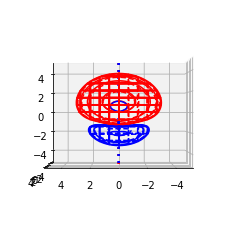

In [39]:
molist = []
for i in range(n):
    coeffs = C[:,i]
    newmo = Mo(aolist,coeffs)
    molist.append(newmo)
plot_implicit(molist[4], 0.01,[-5,5],0,90) #choose HOMO